# Multi-output neural networks

We would like to try to predict all outputs at once using multi-output neural networks. The outputs have different activation functions and different losses that should be applied to each one of them. With neural networks, we create a model adapted to each output.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.layers import Dense, Input, Conv1D, MaxPooling1D, Flatten, Dropout
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV

from scikeras.wrappers import KerasRegressor

In [5]:
path = './Files/After_Feature_Engineering/Split/'

## 1. Predicting all C values at once
General loss: 15.5   
Main problems:
- ATS and HD difference in buildings
- Regression tasks could be improved
Remarks:
- Categorical cross-entropy required one-hot encoded y values


In [19]:
X_train = pd.read_csv('X_train_C.csv', low_memory=False)
X_test = pd.read_csv('X_test_C.csv', low_memory=False)

Y_train = pd.read_csv('Y_train_C.csv', low_memory=False)
Y_test = pd.read_csv('Y_test_C.csv', low_memory=False)

FileNotFoundError: [Errno 2] No such file or directory: 'X_train_C.csv'

In [38]:
input_shape = X_train.shape[1] # Number of features

# Define the input layer
input_layer = Input(shape=(input_shape,))

label_encoder = LabelEncoder()

Y_train['Nail spacing [cm]'] = label_encoder.fit_transform(Y_train['Nail spacing [cm]'])
Y_test['Nail spacing [cm]'] = label_encoder.transform(Y_test['Nail spacing [cm]'])

# Use to_categorical
Y_train_onehot = to_categorical(Y_train['Nail spacing [cm]'], num_classes=3)
Y_test_onehot = to_categorical(Y_test['Nail spacing [cm]'], num_classes=3)


# Define separate branches for each output
nail_spacing_output = Dense(3, activation='softmax', name='nail_spacing')(input_layer)
num_sheathing_panels_output = Dense(3, activation='softmax', name='num_sheathing_panels')(input_layer)
num_end_studs_output = Dense(6, activation='softmax', name='num_end_studs')(input_layer)
total_num_studs_output = Dense(1, activation='linear', name='total_num_studs')(input_layer)
holddown_model_output = Dense(1, activation='linear', name='holddown_model')(input_layer)
tx_output = Dense(1, activation='linear', name='tx')(input_layer)
ty_output = Dense(1, activation='linear', name='ty')(input_layer)

# Combine the outputs into a single model
model = Model(inputs=input_layer, outputs=[nail_spacing_output, num_sheathing_panels_output, 
                                                   num_end_studs_output, total_num_studs_output, 
                                                   holddown_model_output, tx_output, ty_output])

# Compile the model
model.compile(optimizer='adam', 
              loss={'nail_spacing': 'categorical_crossentropy',
                    'num_sheathing_panels': 'categorical_crossentropy',
                    'num_end_studs': 'categorical_crossentropy',
                    'total_num_studs': 'mean_squared_error',
                    'holddown_model': 'mean_squared_error',
                    'tx': 'mean_squared_error',
                    'ty': 'mean_squared_error'},
              metrics={'nail_spacing': 'accuracy',
                       'num_sheathing_panels': 'accuracy',
                       'num_end_studs': 'accuracy',
                       'total_num_studs': 'mae',  # Mean Absolute Error for regression tasks
                       'holddown_model': 'mae',
                       'tx': 'mae',
                       'ty': 'mae'})

# Train the model
model.fit(X_train, {'nail_spacing': Y_train_onehot['Nail spacing [cm]'], 
                    'num_sheathing_panels': Y_train['Number sheathing panels'],
                    'num_end_studs': Y_train['Number end studs'],
                    'total_num_studs': Y_train['Total number studs'],
                    'holddown_model': Y_train['HoldDown Model'],
                    'tx': Y_train['Tx(s)'],
                    'ty': Y_train['Ty(s)']},
          epochs=100, batch_size=32, validation_split=0.2)


# Evaluate the model on the test set
model.evaluate(X_test, {'nail_spacing': Y_test['nail_spacing'], 
                        'num_sheathing_panels': Y_test['num_sheathing_panels'],
                        'num_end_studs': Y_test['num_end_studs'],
                        'total_num_studs': Y_test['total_num_studs'],
                        'holddown_model': Y_test['holddown_model'],
                        'tx': Y_test['tx'],
                        'ty': Y_test['ty']})


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [2]:
def label_encoder(Y_train, Y_test):
    label_encoder_nail_spacing = LabelEncoder()
    Y_train['Nail spacing [cm]'] = label_encoder_nail_spacing.fit_transform(Y_train['Nail spacing [cm]'])
    Y_test['Nail spacing [cm]'] = label_encoder_nail_spacing.transform(Y_test['Nail spacing [cm]'])
    Y_train_onehot_nail_spacing = to_categorical(Y_train['Nail spacing [cm]'], num_classes=3)
    Y_test_onehot_nail_spacing = to_categorical(Y_test['Nail spacing [cm]'], num_classes=3)

    label_encoder_num_sheathing_panels = LabelEncoder()
    Y_train['Number sheathing panels'] = label_encoder_num_sheathing_panels.fit_transform(Y_train['Number sheathing panels'])
    Y_test['Number sheathing panels'] = label_encoder_num_sheathing_panels.transform(Y_test['Number sheathing panels'])
    Y_train_onehot_num_sheathing_panels = to_categorical(Y_train['Number sheathing panels'], num_classes=2)
    Y_test_onehot_num_sheathing_panels = to_categorical(Y_test['Number sheathing panels'], num_classes=2)

    label_encoder_num_end_studs = LabelEncoder()
    Y_train['Number end studs'] = label_encoder_num_end_studs.fit_transform(Y_train['Number end studs'])
    Y_test['Number end studs'] = label_encoder_num_end_studs.transform(Y_test['Number end studs'])
    Y_train_onehot_num_end_studs = to_categorical(Y_train['Number end studs'], num_classes=6)
    Y_test_onehot_num_end_studs = to_categorical(Y_test['Number end studs'], num_classes=6)

    return Y_train_onehot_nail_spacing, Y_test_onehot_nail_spacing, Y_train_onehot_num_sheathing_panels, Y_test_onehot_num_sheathing_panels, Y_train_onehot_num_end_studs, Y_test_onehot_num_end_studs, Y_train, Y_test

In [40]:
input_layer = Input(shape=(input_shape,))

# One hot encoding Y
Y_train_onehot_nail_spacing, Y_test_onehot_nail_spacing, Y_train_onehot_num_sheathing_panels, Y_test_onehot_num_sheathing_panels, Y_train_onehot_num_end_studs, Y_test_onehot_num_end_studs, Y_train, Y_test = label_encoder(Y_train, Y_test)

# Define separate branches for each output
nail_spacing_output = Dense(3, activation='softmax', name='nail_spacing')(input_layer)
num_sheathing_panels_output = Dense(2, activation='softmax', name='num_sheathing_panels')(input_layer)
num_end_studs_output = Dense(6, activation='softmax', name='num_end_studs')(input_layer)
total_num_studs_output = Dense(1, activation='linear', name='total_num_studs')(input_layer)
holddown_model_output = Dense(1, activation='linear', name='holddown_model')(input_layer)
tx_output = Dense(1, activation='linear', name='tx')(input_layer)
ty_output = Dense(1, activation='linear', name='ty')(input_layer)

# Combine the outputs into a single model
model = Model(inputs=input_layer, outputs=[nail_spacing_output, num_sheathing_panels_output, 
                                           num_end_studs_output, total_num_studs_output, 
                                           holddown_model_output, tx_output, ty_output])

# Compile the model
model.compile(optimizer='adam', 
              loss={'nail_spacing': 'categorical_crossentropy',
                    'num_sheathing_panels': 'categorical_crossentropy',
                    'num_end_studs': 'categorical_crossentropy',
                    'total_num_studs': 'mean_squared_error',
                    'holddown_model': 'mean_squared_error',
                    'tx': 'mean_squared_error',
                    'ty': 'mean_squared_error'},
              metrics={'nail_spacing': 'accuracy',
                       'num_sheathing_panels': 'accuracy',
                       'num_end_studs': 'accuracy',
                       'total_num_studs': 'mae',
                       'holddown_model': 'mae',
                       'tx': 'mae',
                       'ty': 'mae'})

# Train the model
model.fit(X_train, {'nail_spacing': Y_train_onehot_nail_spacing, 
                    'num_sheathing_panels': Y_train_onehot_num_sheathing_panels,
                    'num_end_studs': Y_train_onehot_num_end_studs,
                    'total_num_studs': Y_train['Total number studs'],
                    'holddown_model': Y_train['HoldDown Model'],
                    'tx': Y_train['Tx(s)'],
                    'ty': Y_train['Ty(s)']},
          epochs=100, batch_size=32, validation_split=0.2)



Epoch 1/100
1246/1246 [==============================] - 10s 5ms/step - loss: 96.6684 - nail_spacing_loss: 0.0991 - num_sheathing_panels_loss: 0.3223 - num_end_studs_loss: 1.0217 - total_num_studs_loss: 64.6923 - holddown_model_loss: 30.4776 - tx_loss: 0.0293 - ty_loss: 0.0261 - nail_spacing_accuracy: 0.9899 - num_sheathing_panels_accuracy: 0.8697 - num_end_studs_accuracy: 0.6442 - total_num_studs_mae: 6.3216 - holddown_model_mae: 3.4358 - tx_mae: 0.1115 - ty_mae: 0.1016 - val_loss: 47.8061 - val_nail_spacing_loss: 0.0081 - val_num_sheathing_panels_loss: 0.2715 - val_num_end_studs_loss: 0.7845 - val_total_num_studs_loss: 24.9474 - val_holddown_model_loss: 21.7844 - val_tx_loss: 0.0057 - val_ty_loss: 0.0046 - val_nail_spacing_accuracy: 1.0000 - val_num_sheathing_panels_accuracy: 0.8893 - val_num_end_studs_accuracy: 0.7330 - val_total_num_studs_mae: 3.4801 - val_holddown_model_mae: 3.1597 - val_tx_mae: 0.0598 - val_ty_mae: 0.0532
Epoch 2/100
1246/1246 [==============================] - 6

In [42]:
# Evaluate the model on the test set
evaluation_results = model.evaluate(X_test, {'nail_spacing': Y_test_onehot_nail_spacing, 
                                             'num_sheathing_panels': Y_test_onehot_num_sheathing_panels,
                                             'num_end_studs': Y_test_onehot_num_end_studs,
                                             'total_num_studs': Y_test['Total number studs'],
                                             'holddown_model': Y_test['HoldDown Model'],
                                             'tx': Y_test['Tx(s)'],
                                             'ty': Y_test['Ty(s)']},
                                    batch_size=32)

# Extract and print the accuracy for each output
output_metrics = {name: value for name, value in zip(model.metrics_names, evaluation_results)}
print("Metrics on Test Set:")
for output_name, metric_value in output_metrics.items():
    print(f"{output_name}: {metric_value}")


390/390 [==============================] - 1s 3ms/step - loss: 15.5008 - nail_spacing_loss: 0.0000e+00 - num_sheathing_panels_loss: 0.2443 - num_end_studs_loss: 0.3613 - total_num_studs_loss: 2.0881 - holddown_model_loss: 12.7973 - tx_loss: 0.0055 - ty_loss: 0.0043 - nail_spacing_accuracy: 1.0000 - num_sheathing_panels_accuracy: 0.8929 - num_end_studs_accuracy: 0.8455 - total_num_studs_mae: 0.9306 - holddown_model_mae: 2.6309 - tx_mae: 0.0583 - ty_mae: 0.0514
Metrics on Test Set:
loss: 15.500787734985352
nail_spacing_loss: 0.0
num_sheathing_panels_loss: 0.2442822903394699
num_end_studs_loss: 0.36130228638648987
total_num_studs_loss: 2.088104009628296
holddown_model_loss: 12.797307968139648
tx_loss: 0.005488893017172813
ty_loss: 0.004300387110561132
nail_spacing_accuracy: 1.0
num_sheathing_panels_accuracy: 0.8928772211074829
num_end_studs_accuracy: 0.8454990983009338
total_num_studs_mae: 0.9306480884552002
holddown_model_mae: 2.630870819091797
tx_mae: 0.058348290622234344
ty_mae: 0.0514

Useful functions

In [9]:
def label_encoder(Y_train, Y_test):
    """
    Encode categorical labels using LabelEncoder and convert them to one-hot encoding.

    Parameters:
        Y_train (pandas.DataFrame): Training labels.
        Y_test (pandas.DataFrame): Testing labels.

    Returns:
        Tuple of encoded and one-hot encoded labels for nail spacing, number of sheathing panels,
        number of end studs, as well as the original Y_train and Y_test.
    """
    # Encode and one-hot encode 'Nail spacing [cm]'
    label_encoder_nail_spacing = LabelEncoder()
    Y_train['Nail spacing [cm]'] = label_encoder_nail_spacing.fit_transform(Y_train['Nail spacing [cm]'])
    Y_test['Nail spacing [cm]'] = label_encoder_nail_spacing.transform(Y_test['Nail spacing [cm]'])
    Y_train_onehot_nail_spacing = to_categorical(Y_train['Nail spacing [cm]'], num_classes=3)
    Y_test_onehot_nail_spacing = to_categorical(Y_test['Nail spacing [cm]'], num_classes=3)

    # Encode and one-hot encode 'Number sheathing panels'
    label_encoder_num_sheathing_panels = LabelEncoder()
    Y_train['Number sheathing panels'] = label_encoder_num_sheathing_panels.fit_transform(Y_train['Number sheathing panels'])
    Y_test['Number sheathing panels'] = label_encoder_num_sheathing_panels.transform(Y_test['Number sheathing panels'])
    Y_train_onehot_num_sheathing_panels = to_categorical(Y_train['Number sheathing panels'], num_classes=2)
    Y_test_onehot_num_sheathing_panels = to_categorical(Y_test['Number sheathing panels'], num_classes=2)

    # Encode and one-hot encode 'Number end studs'
    label_encoder_num_end_studs = LabelEncoder()
    Y_train['Number end studs'] = label_encoder_num_end_studs.fit_transform(Y_train['Number end studs'])
    Y_test['Number end studs'] = label_encoder_num_end_studs.transform(Y_test['Number end studs'])
    Y_train_onehot_num_end_studs = to_categorical(Y_train['Number end studs'], num_classes=6)
    Y_test_onehot_num_end_studs = to_categorical(Y_test['Number end studs'], num_classes=6)

    # Return the results
    return (
        Y_train_onehot_nail_spacing, Y_test_onehot_nail_spacing,
        Y_train_onehot_num_sheathing_panels, Y_test_onehot_num_sheathing_panels,
        Y_train_onehot_num_end_studs, Y_test_onehot_num_end_studs,
        Y_train, Y_test
    )


def plot_loss(history):
    """
    Plot training and validation loss over epochs.
    Uses logarithmic scale for the x-axis for better visualization.

    Parameters:
        history (keras.callbacks.History): The training history obtained from model training.

    Returns:
        None
    """
    plt.figure(figsize=(15, 6))

    # Plot training loss
    plt.subplot(1, 2, 1)
    for output in history.history.keys():
        if output.endswith('loss') and not output.startswith('val_') and output != 'loss':
            plt.plot(history.history[output], label=output)

    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.xscale('log')
    plt.ylabel('Loss')
    plt.legend()

    # Plot validation loss
    plt.subplot(1, 2, 2)
    for output in history.history.keys():
        if output.startswith('val_') and output.endswith('loss') and output != 'val_loss':
            plt.plot(history.history[output], label=output[4:])

    plt.title('Validation Loss')
    plt.xlabel('Epoch')
    plt.xscale('log')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

## 1. Predicting wall specification (Type C)

In [4]:
X_train_C_1 = pd.read_csv(path + "X_train_C_part1_FE.csv", low_memory=False)
X_test_C_1 = pd.read_csv(path + "X_test_C_part1_FE.csv", low_memory=False)

Y_train_C_1 = pd.read_csv(path + "Y_train_C_part1_FE.csv", low_memory=False)
Y_test_C_1 = pd.read_csv(path + "Y_test_C_part1_FE.csv", low_memory=False)

This code defines and trains a neural network model for a multi-output regression and classification task.
The model predicts multiple outputs, including categorical and numerical values.

1. **Input Layer Definition:**
    - The input layer is defined based on the shape of the training data `X_train_C_1`.

2. **Label Encoding and One-Hot Encoding:**
    - Categorical labels in `Y_train_C_1` and `Y_test_C_1` are encoded using `label_encoder` function,
      and one-hot encoded for each categorical variable.

3. **Output Layers:**
    - Separate output layers are defined for different prediction tasks:
        - `nail_spacing_output`: 3-class classification for nail spacing.
        - `num_sheathing_panels_output`: 2-class classification for number of sheathing panels.
        - `num_end_studs_output`: 6-class classification for number of end studs.
        - `total_num_studs_output`: Regression for total number of studs.
        - `holddown_model_output`: Regression for holddown model/ATS.

4. **Model Compilation:**
    - The model is compiled with specific loss functions and metrics for each output.

5. **Learning Rate Adjustment Callback:**
    - `ReduceLROnPlateau` callback is implemented to adjust the learning rate based on validation loss.

6. **Model Training:**
    - The model is trained using the training data and corresponding one-hot encoded labels.
    - Validation data is provided for monitoring model performance during training.
    - Training history is stored in the variable `history_C_1`.

7. **Plotting Training and Validation Loss:**
    - The `plot_loss` function is used to visualize the training and validation loss over epochs.


Epoch 1/100
1557/1557 [==============================] - 14s 7ms/step - loss: 85.2961 - nail_spacing_loss: 0.7212 - num_sheathing_panels_loss: 0.3158 - num_end_studs_loss: 0.9658 - total_num_studs_loss: 53.7928 - holddown/ats_loss: 29.5006 - nail_spacing_accuracy: 0.7034 - num_sheathing_panels_accuracy: 0.8747 - num_end_studs_accuracy: 0.6814 - total_num_studs_mae: 5.5782 - holddown/ats_mae: 3.4467 - val_loss: 44.8695 - val_nail_spacing_loss: 0.6376 - val_num_sheathing_panels_loss: 0.2690 - val_num_end_studs_loss: 0.7441 - val_total_num_studs_loss: 20.9278 - val_holddown/ats_loss: 22.2910 - val_nail_spacing_accuracy: 0.7378 - val_num_sheathing_panels_accuracy: 0.8918 - val_num_end_studs_accuracy: 0.7573 - val_total_num_studs_mae: 3.2475 - val_holddown/ats_mae: 3.1856 - lr: 0.0010
Epoch 2/100
1557/1557 [==============================] - 10s 7ms/step - loss: 36.4688 - nail_spacing_loss: 0.6109 - num_sheathing_panels_loss: 0.2571 - num_end_studs_loss: 0.6814 - total_num_studs_loss: 16.326

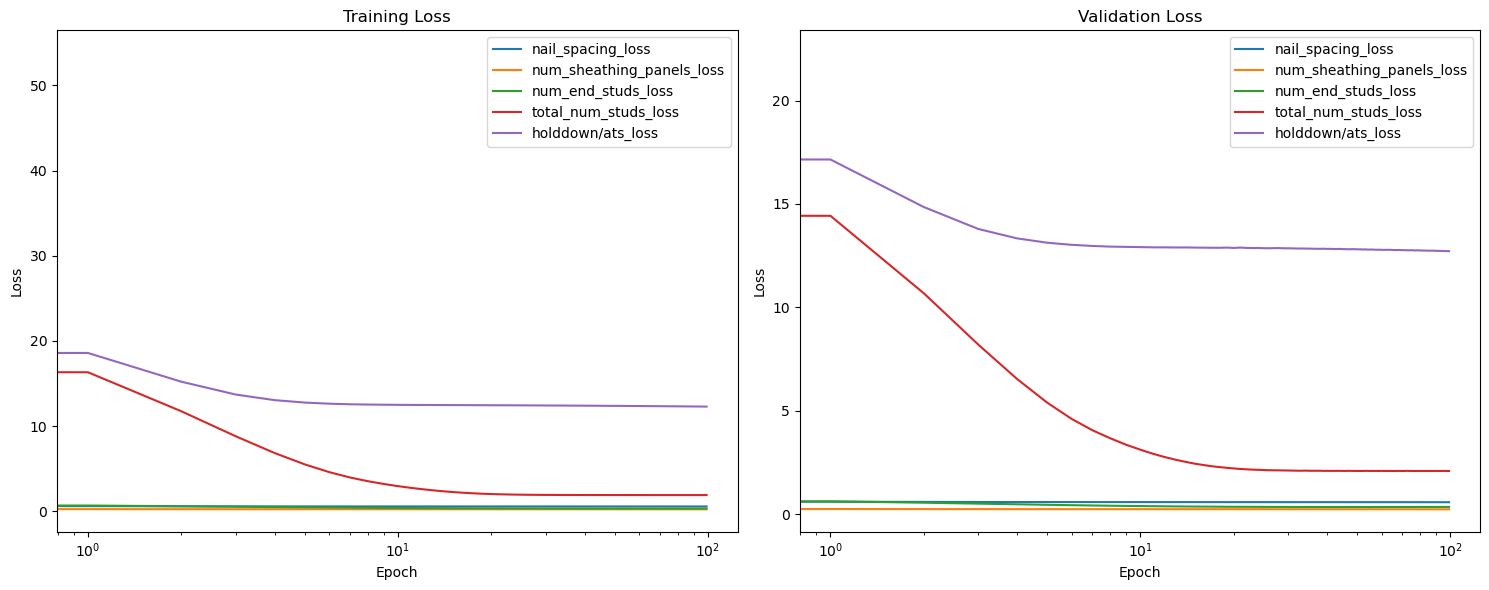

In [31]:
# Define the input layer
input_layer_C_1 = Input(shape=(X_train_C_1.shape[1],))

# One hot encoding Y
Y_train_onehot_nail_spacing, Y_test_onehot_nail_spacing, Y_train_onehot_num_sheathing_panels, Y_test_onehot_num_sheathing_panels, Y_train_onehot_num_end_studs, Y_test_onehot_num_end_studs, Y_train_C_1, Y_test_C_1 = label_encoder(Y_train_C_1, Y_test_C_1)

# Output layers
nail_spacing_output = Dense(3, activation='softmax', name='nail_spacing')(input_layer_C_1)
num_sheathing_panels_output = Dense(2, activation='softmax', name='num_sheathing_panels')(input_layer_C_1)
num_end_studs_output = Dense(6, activation='softmax', name='num_end_studs')(input_layer_C_1)
total_num_studs_output = Dense(1, activation='linear', name='total_num_studs')(input_layer_C_1)
holddown_model_output = Dense(1, activation='linear', name='holddown/ats')(input_layer_C_1)

# Combine the outputs into a single model
model_C_1 = Model(inputs=input_layer_C_1, outputs=[nail_spacing_output, num_sheathing_panels_output, 
                                           num_end_studs_output, total_num_studs_output, 
                                           holddown_model_output])

# Compile the model
model_C_1.compile(optimizer='adam', 
              loss={'nail_spacing': 'categorical_crossentropy',
                    'num_sheathing_panels': 'categorical_crossentropy',
                    'num_end_studs': 'categorical_crossentropy',
                    'total_num_studs': 'mean_squared_error',
                    'holddown/ats': 'mean_squared_error'
                    },
              metrics={'nail_spacing': 'accuracy',
                       'num_sheathing_panels': 'accuracy',
                       'num_end_studs': 'accuracy',
                       'total_num_studs': 'mae',
                       'holddown/ats': 'mae'
                       })

# Implement ReduceLROnPlateau callback
# Went from 0.02 to 0.008 in total loss with this line
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.00001)


# Train the model
history_C_1 = model_C_1.fit(X_train_C_1, {'nail_spacing': Y_train_onehot_nail_spacing, 
                    'num_sheathing_panels': Y_train_onehot_num_sheathing_panels,
                    'num_end_studs': Y_train_onehot_num_end_studs,
                    'total_num_studs': Y_train_C_1['Total number studs'],
                    'holddown/ats': Y_train_C_1['HoldDown Model / ATS']
                    },
          epochs=100, batch_size=32, validation_data = (X_test_C_1, {'nail_spacing': Y_test_onehot_nail_spacing,
                                                                        'num_sheathing_panels': Y_test_onehot_num_sheathing_panels,
                                                                        'num_end_studs': Y_test_onehot_num_end_studs,
                                                                        'total_num_studs': Y_test_C_1['Total number studs'],
                                                                        'holddown/ats': Y_test_C_1['HoldDown Model / ATS']
                                             }), callbacks=[reduce_lr])

# Plot training and validation loss
plot_loss(history_C_1)

In [32]:
# Evaluate the model on the test set
evaluation_results = model_C_1.evaluate(X_test_C_1, {'nail_spacing': Y_test_onehot_nail_spacing, 
                                             'num_sheathing_panels': Y_test_onehot_num_sheathing_panels,
                                             'num_end_studs': Y_test_onehot_num_end_studs,
                                             'total_num_studs': Y_test_C_1['Total number studs'],
                                             'holddown/ats': Y_test_C_1['HoldDown Model / ATS']
                                             },
                                    batch_size=32)

# Extract and print the accuracy for each output
output_metrics = {name: value for name, value in zip(model_C_1.metrics_names, evaluation_results)}
print("Metrics on Test Set:")
for output_name, metric_value in output_metrics.items():
    print(f"{output_name}: {metric_value}")

390/390 [==============================] - 2s 5ms/step - loss: 15.9990 - nail_spacing_loss: 0.5860 - num_sheathing_panels_loss: 0.2417 - num_end_studs_loss: 0.3575 - total_num_studs_loss: 2.0935 - holddown/ats_loss: 12.7203 - nail_spacing_accuracy: 0.7547 - num_sheathing_panels_accuracy: 0.8930 - num_end_studs_accuracy: 0.8501 - total_num_studs_mae: 0.9288 - holddown/ats_mae: 2.6405
Metrics on Test Set:
loss: 15.999007225036621
nail_spacing_loss: 0.5859500765800476
num_sheathing_panels_loss: 0.24173741042613983
num_end_studs_loss: 0.3575356900691986
total_num_studs_loss: 2.093506097793579
holddown/ats_loss: 12.720271110534668
nail_spacing_accuracy: 0.7546775937080383
num_sheathing_panels_accuracy: 0.8930377960205078
num_end_studs_accuracy: 0.8500762581825256
total_num_studs_mae: 0.9287946820259094
holddown/ats_mae: 2.6404762268066406


## 2. Predicting Building Parameters (Type C)

In [6]:
X_train_C_2 = pd.read_csv(path + "X_train_C_part2_FE.csv", low_memory=False)
X_test_C_2 = pd.read_csv(path + "X_test_C_part2_FE.csv", low_memory=False)

Y_train_C_2 = pd.read_csv(path + "Y_train_C_part2_FE.csv", low_memory=False)
Y_test_C_2 = pd.read_csv(path + "Y_test_C_part2_FE.csv", low_memory=False)

This code defines and trains a neural network model for a regression task with two outputs (tx and ty).
Different activation functions are used for the output layers to explore their impact on performance.
The model predicts two continuous outputs, 'tx' and 'ty', representing some spatial coordinates.

1. **Input Layer Definition:**
    - The input layer is defined based on the shape of the training data `X_train_C_2`.

2. **Output Layers:**
    - Separate output layers are defined for 'tx' and 'ty' with different activation functions:

        | Activation Function | MAE for 'tx' | MAE for 'ty' |
        |----------------------|--------------|--------------|
        | Linear               | 0.056        | 0.049        |
        | ReLU                 | 0.056        | 0.047        |
        | Leaky ReLU           | 0.056        | 0.048        |
        | Swish                | 0.054        | 0.046        |
        | Softplus             | 0.055        | 0.046        |
        | Tanh                 | 0.064        | 0.052        |

    Following our measurements, we chose to use the swish activation function as it performs the best.



3. **Model Compilation:**
    - The model is compiled with specific loss functions and metrics for each output ('tx' and 'ty').

4. **Learning Rate Adjustment Callback:**
    - `ReduceLROnPlateau` callback is implemented to adjust the learning rate based on validation loss.

5. **Model Training:**
    - The model is trained using the training data and corresponding labels for 'tx' and 'ty'.
    - Validation data is provided for monitoring model performance during training.
    - Training history is stored in the variable `history_C_2`.

6. **Plotting Training and Validation Loss:**
    - The `plot_loss` function is used to visualize the training and validation loss over epochs.


Epoch 1/100
5/5 [==============================] - 2s 223ms/step - loss: 0.8030 - tx_loss: 0.3837 - ty_loss: 0.4193 - tx_mae: 0.5769 - ty_mae: 0.5541 - val_loss: 0.5884 - val_tx_loss: 0.2828 - val_ty_loss: 0.3057 - val_tx_mae: 0.4775 - val_ty_mae: 0.4947 - lr: 0.0010
Epoch 2/100
5/5 [==============================] - 0s 27ms/step - loss: 0.5733 - tx_loss: 0.2477 - ty_loss: 0.3256 - tx_mae: 0.4364 - ty_mae: 0.5101 - val_loss: 0.4789 - val_tx_loss: 0.2160 - val_ty_loss: 0.2628 - val_tx_mae: 0.4116 - val_ty_mae: 0.4598 - lr: 0.0010
Epoch 3/100
5/5 [==============================] - 0s 26ms/step - loss: 0.4821 - tx_loss: 0.2011 - ty_loss: 0.2810 - tx_mae: 0.3894 - ty_mae: 0.4793 - val_loss: 0.4299 - val_tx_loss: 0.1993 - val_ty_loss: 0.2307 - val_tx_mae: 0.4012 - val_ty_mae: 0.4318 - lr: 0.0010
Epoch 4/100
5/5 [==============================] - 0s 27ms/step - loss: 0.4218 - tx_loss: 0.1872 - ty_loss: 0.2347 - tx_mae: 0.3683 - ty_mae: 0.4375 - val_loss: 0.3722 - val_tx_loss: 0.1712 - val_ty

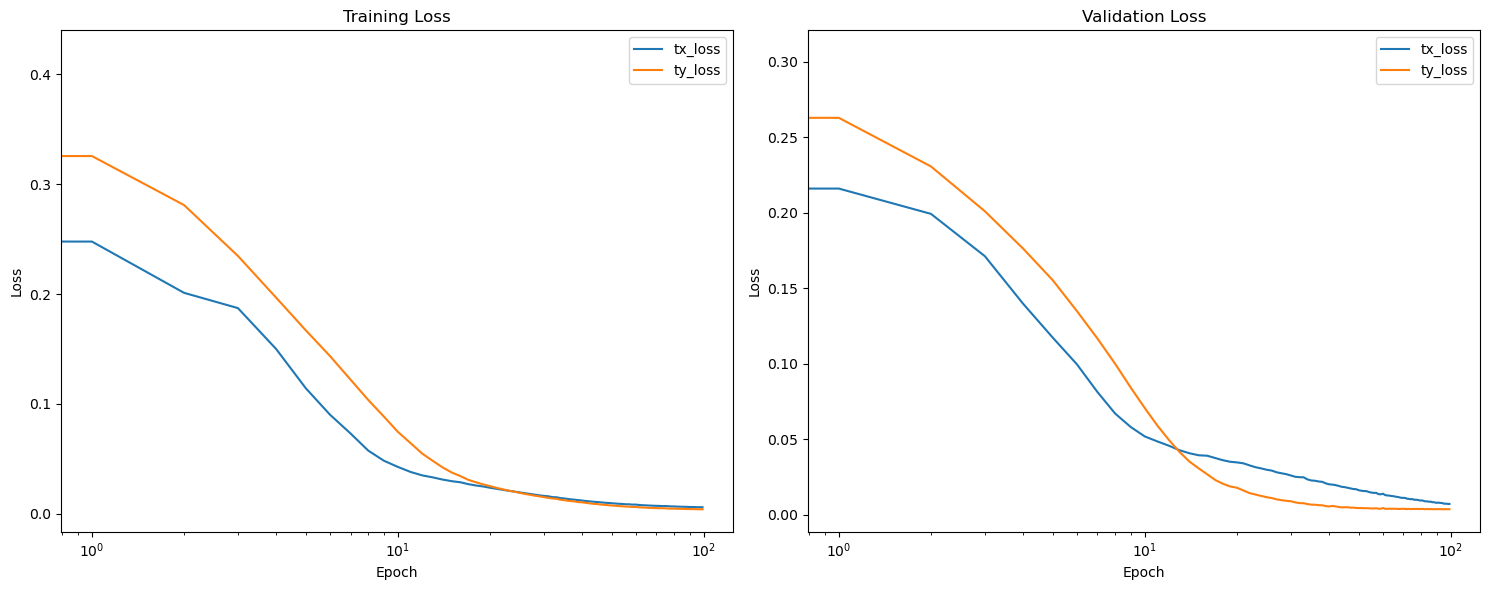

In [11]:
# Define the input layer
input_layer_C_2 = Input(shape=(X_train_C_2.shape[1],))

# Define separate branches for each output
tx_output = Dense(1, activation='swish', name='tx')(input_layer_C_2)
ty_output = Dense(1, activation='swish', name='ty')(input_layer_C_2)

# Combine the outputs into a single model
model_C_2 = Model(inputs=input_layer_C_2, outputs=[tx_output, ty_output])

# Compile the model
model_C_2.compile(optimizer='adam', 
              loss={
                    'tx': 'mean_squared_error',
                    'ty': 'mean_squared_error'
                    },
              metrics={
                       'tx': 'mae',
                       'ty': 'mae'
                       })

# Implement ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.00001)

# Train the model
history_C_2 = model_C_2.fit(X_train_C_2, {
                        'tx': Y_train_C_2['Tx(s)'],
                        'ty': Y_train_C_2['Ty(s)']
                        },
          epochs=100, batch_size=32, validation_data = (X_test_C_2, {
                                                    'tx': Y_test_C_2['Tx(s)'],
                                                    'ty': Y_test_C_2['Ty(s)']
                                             }), callbacks=[reduce_lr])

plot_loss(history_C_2)


Let's try Bagging Regressor because it performed really well with a total loss of 0.008 for all regression outputs, which means that for Tx and Ty, the loss must be less than 0.008. However, even with this implementation the loss is still at 0.009

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Number of models to create
n_estimators = 5

# List to store individual model predictions
pred_tx_list = []
pred_ty_list = []

for _ in range(n_estimators):
    tx_output = Dense(1, activation='swish', name='tx')(input_layer_C_2)
    ty_output = Dense(1, activation='swish', name='ty')(input_layer_C_2)

    # Combine the outputs into a single model
    model = Model(inputs=input_layer_C_2, outputs=[tx_output, ty_output])

    # Compile the model
    model.compile(optimizer='adam', 
                loss={
                        'tx': 'mean_squared_error',
                        'ty': 'mean_squared_error'
                        },
                metrics={
                        'tx': 'mae',
                        'ty': 'mae'
                        })
    
    # Train the model on the training data
    model.fit(X_train_C_2, {'tx': Y_train_C_2['Tx(s)'], 'ty': Y_train_C_2['Ty(s)']}, epochs=100, batch_size=32)

    # Make predictions on the test set
    predictions = model.predict(X_test_C_2)

    # Assuming the output shape is (batch_size, 1) for each output
    pred_tx = predictions[0][:, 0]
    pred_ty = predictions[1][:, 0]
    
    # Store predictions
    pred_tx_list.append(pred_tx)
    pred_ty_list.append(pred_ty)

# Combine predictions from all models
final_pred_tx = np.mean(pred_tx_list, axis=0)
final_pred_ty = np.mean(pred_ty_list, axis=0)

# Evaluate the performance
mse_tx = mean_squared_error(Y_test_C_2['Tx(s)'], final_pred_tx)
mae_tx = mean_absolute_error(Y_test_C_2['Tx(s)'], final_pred_tx)

mse_ty = mean_squared_error(Y_test_C_2['Ty(s)'], final_pred_ty)
mae_ty = mean_absolute_error(Y_test_C_2['Ty(s)'], final_pred_ty)

print(f'Tx MSE: {mse_tx}, Tx MAE: {mae_tx}')
print(f'Ty MSE: {mse_ty}, Ty MAE: {mae_ty}')



Epoch 1/100
5/5 [==============================] - 1s 3ms/step - loss: 0.3829 - tx_loss: 0.2646 - ty_loss: 0.1183 - tx_mae: 0.4288 - ty_mae: 0.2881
Epoch 2/100
5/5 [==============================] - 0s 6ms/step - loss: 0.1967 - tx_loss: 0.1152 - ty_loss: 0.0815 - tx_mae: 0.2777 - ty_mae: 0.2295
Epoch 3/100
5/5 [==============================] - 0s 3ms/step - loss: 0.1422 - tx_loss: 0.0822 - ty_loss: 0.0600 - tx_mae: 0.2389 - ty_mae: 0.2046
Epoch 4/100
5/5 [==============================] - 0s 2ms/step - loss: 0.1095 - tx_loss: 0.0652 - ty_loss: 0.0444 - tx_mae: 0.2041 - ty_mae: 0.1663
Epoch 5/100
5/5 [==============================] - 0s 16ms/step - loss: 0.0728 - tx_loss: 0.0436 - ty_loss: 0.0291 - tx_mae: 0.1755 - ty_mae: 0.1419
Epoch 6/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0526 - tx_loss: 0.0279 - ty_loss: 0.0247 - tx_mae: 0.1336 - ty_mae: 0.1285
Epoch 7/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0471 - tx_loss: 0.0273 - ty_loss: 0.01

#### Cross-validation

Ran in 160 minuts and yet even with trying multiple sets of parameters, it did not improve the overall loss.

In [5]:
def create_model_C_2(learning_rate=0.001, activation='swish', factor=0.2, patience=10, min_lr=0.00001):
    input_layer_C_2 = Input(shape=(X_train_C_2.shape[1],))
    tx_output = Dense(1, activation=activation, name='tx')(input_layer_C_2)
    ty_output = Dense(1, activation=activation, name='ty')(input_layer_C_2)

    model = Model(inputs=input_layer_C_2, outputs=[tx_output, ty_output])

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss={'tx': 'mean_squared_error', 'ty': 'mean_squared_error'},
                  metrics={'tx': 'mae', 'ty': 'mae'})

    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=factor, patience=patience, min_lr=min_lr)
    model.callbacks = [reduce_lr]
    return model

We had to seperate Tx and Ty when computing the cross-validation because GridSearch can only take one estimator at a time

In [21]:
from sklearn.model_selection import KFold
# Define the parameter grid for GridSearchCV
param_grid = {
    'model__learning_rate': [0.001, 0.0001],
    'model__activation': ['linear', 'relu', 'leaky_relu', 'swish', 'softplus', 'tanh'],
    'epochs': [50, 100, 150],
    'model__batch_size': [16, 32, 64],
    'model__factor': [0.1, 0.2],
    'model__patience': [5, 10, 15],
    'model__min_lr': [0.00001, 0.0001]
}


# Modify your create_model_C_2 function to accept a 'model_type' argument
def create_model_C_2(model_type='tx', learning_rate=0.001, activation='swish', factor=0.2, patience=10, min_lr=0.00001, **kwargs):
    input_layer_C_2 = Input(shape=(X_train_C_2.shape[1],))
    
    # Use the 'model_type' argument to determine which output to create
    if model_type == 'tx':
        output = Dense(1, activation=activation, name='tx')(input_layer_C_2)
    elif model_type == 'ty':
        output = Dense(1, activation=activation, name='ty')(input_layer_C_2)
    else:
        raise ValueError("Invalid model_type. Use 'tx' or 'ty'.")

    model = Model(inputs=input_layer_C_2, outputs=output)

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error',
                  metrics='mae')

    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=factor, patience=patience, min_lr=min_lr)
    model.callbacks = [reduce_lr]
    return model


# Wrap the Keras model using KerasRegressor
keras_regressor_tx = KerasRegressor(model=lambda learning_rate, activation, factor, patience, min_lr, batch_size:
    create_model_C_2(model_type='tx', learning_rate=learning_rate, activation=activation, factor=factor, patience=patience, min_lr=min_lr, batch_size=batch_size),
    epochs=50, verbose=0)

keras_regressor_ty = KerasRegressor(model=lambda learning_rate, activation, factor, patience, min_lr, batch_size:
    create_model_C_2(model_type='ty', learning_rate=learning_rate, activation=activation, factor=factor, patience=patience, min_lr=min_lr, batch_size=batch_size),
    epochs=50, verbose=0)


# Use KFold cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Create the GridSearchCV instance for both 'tx' and 'ty'
grid_search_tx = GridSearchCV(estimator=keras_regressor_tx, param_grid=param_grid, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_ty = GridSearchCV(estimator=keras_regressor_ty, param_grid=param_grid, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the GridSearchCV instance to your data
grid_search_result_tx = grid_search_tx.fit(X_train_C_2, Y_train_C_2['Tx(s)'])  # Use 'tx' column of Y_train_C_2
grid_search_result_ty = grid_search_ty.fit(X_train_C_2, Y_train_C_2['Ty(s)'])  # Use 'ty' column of Y_train_C_2

# Print the best parameters and their corresponding mean test scores
print("Best Parameters (tx): ", grid_search_result_tx.best_params_)
print("Best Mean Test Score (tx): ", grid_search_result_tx.best_score_)

print("Best Parameters (ty): ", grid_search_result_ty.best_params_)
print("Best Mean Test Score (ty): ", grid_search_result_ty.best_score_)




c:\Users\anejj\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
c:\Users\anejj\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Parameters (tx):  {'epochs': 150, 'model__activation': 'softplus', 'model__batch_size': 32, 'model__factor': 0.1, 'model__learning_rate': 0.001, 'model__min_lr': 1e-05, 'model__patience': 15}
Best Mean Test Score (tx):  -0.0061000747557187745
Best Parameters (ty):  {'epochs': 150, 'model__activation': 'softplus', 'model__batch_size': 32, 'model__factor': 0.1, 'model__learning_rate': 0.001, 'model__min_lr': 0.0001, 'model__patience': 15}
Best Mean Test Score (ty):  -0.004111967720104843


In [16]:
# Evaluate the model on the test set
evaluation_results = model_C_2.evaluate(X_test_C_2, {
                                                    'tx': Y_test_C_2['Tx(s)'],
                                                    'ty': Y_test_C_2['Ty(s)']
                                             },
                                    batch_size=32)

# Extract and print the accuracy for each output
output_metrics = {name: value for name, value in zip(model_C_2.metrics_names, evaluation_results)}
print("Metrics on Test Set:")
for output_name, metric_value in output_metrics.items():
    print(f"{output_name}: {metric_value}")

2/2 [==============================] - 0s 6ms/step - loss: 0.0092 - tx_loss: 0.0056 - ty_loss: 0.0036 - tx_mae: 0.0577 - ty_mae: 0.0461
Metrics on Test Set:
loss: 0.009233588352799416
tx_loss: 0.005585492588579655
ty_loss: 0.0036480955313891172
tx_mae: 0.05773045867681503
ty_mae: 0.04608098417520523


## 3. Predicting Building Safety (Type D)

In [5]:
X_train_D = df = pd.read_csv(path + "X_train_D_FE.csv", low_memory=False)
X_test_D = pd.read_csv(path + "X_test_D_FE.csv", low_memory=False)

Y_train_D = df = pd.read_csv(path + "Y_train_d_FE.csv", low_memory=False)
Y_test_D = pd.read_csv(path + "Y_test_D_FE.csv", low_memory=False)

# Chnage the column name because Python doesn't support special characters
column_names = ['omega_x', 'omega_y', 'mu_x', 'mu_y', 'cmr', 'ssf','acmr', 'io-ln', 'io-b', 'ls-ln', 'ls-b', 'cp-ln', 'cp-b']
Y_train_D.columns = column_names
Y_test_D.columns = column_names


Epoch 1/100
5/5 [==============================] - 9s 623ms/step - loss: 66.4897 - omega_x_loss: 15.2482 - omega_y_loss: 19.1200 - mu_x_loss: 9.3361 - mu_y_loss: 7.0338 - cmr_loss: 3.2164 - ssf_loss: 1.1973 - acmr_loss: 6.2569 - io-ln_loss: 0.8487 - io-b_loss: 0.9858 - ls-ln_loss: 0.6159 - ls-b_loss: 1.2570 - cp-ln_loss: 0.9102 - cp-b_loss: 0.4631 - omega_x_mae: 3.0865 - omega_y_mae: 3.3814 - mu_x_mae: 2.5385 - mu_y_mae: 2.1768 - cmr_mae: 1.5009 - ssf_mae: 0.8854 - acmr_mae: 2.0208 - io-ln_mae: 0.7216 - io-b_mae: 0.7638 - ls-ln_mae: 0.6055 - ls-b_mae: 0.8815 - cp-ln_mae: 0.7343 - cp-b_mae: 0.5270 - val_loss: 46.5201 - val_omega_x_loss: 12.3250 - val_omega_y_loss: 15.2750 - val_mu_x_loss: 5.3331 - val_mu_y_loss: 4.0414 - val_cmr_loss: 1.7403 - val_ssf_loss: 0.6997 - val_acmr_loss: 3.0046 - val_io-ln_loss: 0.5834 - val_io-b_loss: 0.6991 - val_ls-ln_loss: 0.8600 - val_ls-b_loss: 0.3838 - val_cp-ln_loss: 1.1203 - val_cp-b_loss: 0.4544 - val_omega_x_mae: 2.7346 - val_omega_y_mae: 3.2225 - v

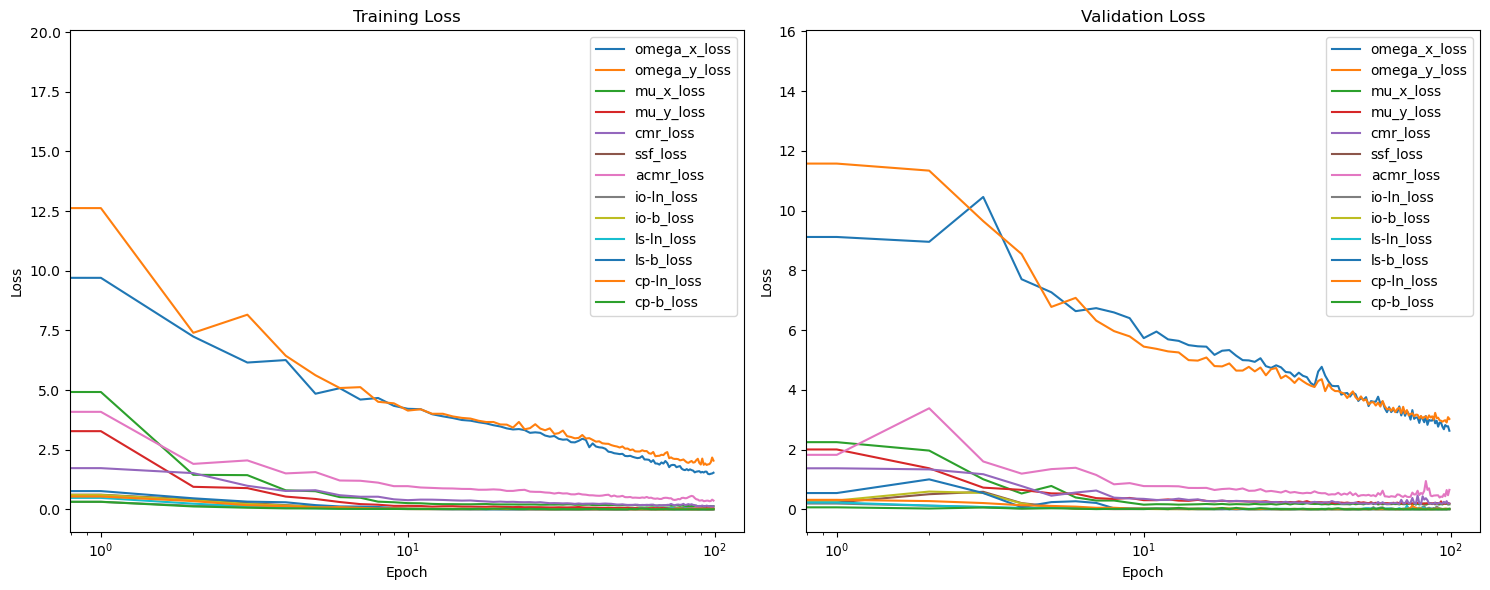

In [34]:
# Define the input layer
input_layer_D = Input(shape=(X_train_D.shape[1],))

# Define separate branches for each output
omega_x_output = Dense(1, activation='linear', name='omega_x')(input_layer_D)
omega_y_output = Dense(1, activation='linear', name='omega_y')(input_layer_D)
mu_x_output = Dense(1, activation='linear', name='mu_x')(input_layer_D)
mu_y_output = Dense(1, activation='linear', name='mu_y')(input_layer_D)
cmr_output = Dense(1, activation='linear', name='cmr')(input_layer_D)
ssf_output = Dense(1, activation='linear', name='ssf')(input_layer_D)
acmr_output = Dense(1, activation='linear', name='acmr')(input_layer_D)
io_ln_output = Dense(1, activation='linear', name='io-ln')(input_layer_D)
io_b_output = Dense(1, activation='linear', name='io-b')(input_layer_D)
ls_ln_output = Dense(1, activation='linear', name='ls-ln')(input_layer_D)
ls_b_output = Dense(1, activation='linear', name='ls-b')(input_layer_D)
cp_ln_output = Dense(1, activation='linear', name='cp-ln')(input_layer_D)
cp_b_output = Dense(1, activation='linear', name='cp-b')(input_layer_D)

# Combine the outputs into a single model
model_D = Model(inputs=input_layer_D, outputs=[omega_x_output, omega_y_output, 
                                               mu_x_output, mu_y_output,
                                               cmr_output, ssf_output, acmr_output,
                                               io_ln_output, io_b_output,
                                               ls_ln_output, ls_b_output,
                                               cp_ln_output, cp_b_output])

# Compile the model
model_D.compile(optimizer='adam', 
              loss={
                        'omega_x': 'mean_squared_error',
                        'omega_y': 'mean_squared_error',
                        'mu_x': 'mean_squared_error',
                        'mu_y': 'mean_squared_error',
                        'cmr': 'mean_squared_error',
                        'ssf': 'mean_squared_error',
                        'acmr': 'mean_squared_error',
                        'io-ln': 'mean_squared_error',
                        'io-b': 'mean_squared_error',
                        'ls-ln': 'mean_squared_error',
                        'ls-b': 'mean_squared_error',
                        'cp-ln': 'mean_squared_error',
                        'cp-b': 'mean_squared_error'
                    },
              metrics={
                       'omega_x': 'mae',
                        'omega_y': 'mae',
                        'mu_x': 'mae',
                        'mu_y': 'mae',
                        'cmr': 'mae',
                        'ssf': 'mae',
                        'acmr': 'mae',
                        'io-ln': 'mae',
                        'io-b': 'mae',
                        'ls-ln': 'mae',
                        'ls-b': 'mae',
                        'cp-ln': 'mae',
                        'cp-b': 'mae'
                       })
# Implement ReduceLROnPlateau callback
# Went from 6.8 to 6.9 in total loss with this line. Could be improved with cross-validation
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.00001)

# Train the model
history_D = model_D.fit(X_train_D, {
                        'omega_x': Y_train_D['omega_x'],
                        'omega_y': Y_train_D['omega_y'],
                        'mu_x': Y_train_D['mu_x'],
                        'mu_y': Y_train_D['mu_y'],
                        'cmr': Y_train_D['cmr'],
                        'ssf': Y_train_D['ssf'],
                        'acmr': Y_train_D['acmr'],
                        'io-ln': Y_train_D['io-ln'],
                        'io-b': Y_train_D['io-b'],
                        'ls-ln': Y_train_D['ls-ln'],
                        'ls-b': Y_train_D['ls-b'],
                        'cp-ln': Y_train_D['cp-ln'],
                        'cp-b': Y_train_D['cp-b']
                        
                        },
          epochs=100, batch_size=32, validation_data=(X_test_D, {
                                                            'omega_x': Y_test_D['omega_x'],
                                                            'omega_y': Y_test_D['omega_y'],
                                                            'mu_x': Y_test_D['mu_x'],
                                                            'mu_y': Y_test_D['mu_y'],
                                                            'cmr': Y_test_D['cmr'],
                                                            'ssf': Y_test_D['ssf'],
                                                            'acmr': Y_test_D['acmr'],
                                                            'io-ln': Y_test_D['io-ln'],
                                                            'io-b': Y_test_D['io-b'],
                                                            'ls-ln': Y_test_D['ls-ln'],
                                                            'ls-b': Y_test_D['ls-b'],
                                                            'cp-ln': Y_test_D['cp-ln'],
                                                            'cp-b': Y_test_D['cp-b']
                                                            }
                                                  ))

plot_loss(history_D)

In [28]:
# Evaluate the model on the test set
evaluation_results = model_D.evaluate(X_test_D, {
                                                    'omega_x': Y_test_D['omega_x'],
                                                    'omega_y': Y_test_D['omega_y'],
                                                    'mu_x': Y_test_D['mu_x'],
                                                    'mu_y': Y_test_D['mu_y'],
                                                    'cmr': Y_test_D['cmr'],
                                                    'ssf': Y_test_D['ssf'],
                                                    'acmr': Y_test_D['acmr'],
                                                    'io-ln': Y_test_D['io-ln'],
                                                    'io-b': Y_test_D['io-b'],
                                                    'ls-ln': Y_test_D['ls-ln'],
                                                    'ls-b': Y_test_D['ls-b'],
                                                    'cp-ln': Y_test_D['cp-ln'],
                                                    'cp-b': Y_test_D['cp-b']
                                             },
                                    batch_size=32)

# Extract and print the accuracy for each output
output_metrics = {name: value for name, value in zip(model_D.metrics_names, evaluation_results)}
print("Metrics on Test Set:")
for output_name, metric_value in output_metrics.items():
    print(f"{output_name}: {metric_value}")

2/2 [==============================] - 0s 8ms/step - loss: 7.1782 - omega_x_loss: 2.8929 - omega_y_loss: 3.0461 - mu_x_loss: 0.1956 - mu_y_loss: 0.2093 - cmr_loss: 0.3017 - ssf_loss: 0.0057 - acmr_loss: 0.3959 - io-ln_loss: 0.0119 - io-b_loss: 0.0044 - ls-ln_loss: 0.0104 - ls-b_loss: 0.0653 - cp-ln_loss: 0.0229 - cp-b_loss: 0.0162 - omega_x_mae: 1.0821 - omega_y_mae: 1.3465 - mu_x_mae: 0.3142 - mu_y_mae: 0.2739 - cmr_mae: 0.4480 - ssf_mae: 0.0508 - acmr_mae: 0.5267 - io-ln_mae: 0.0854 - io-b_mae: 0.0544 - ls-ln_mae: 0.0724 - ls-b_mae: 0.1853 - cp-ln_mae: 0.1274 - cp-b_mae: 0.0919
Metrics on Test Set:
loss: 7.17819881439209
omega_x_loss: 2.8929288387298584
omega_y_loss: 3.0461268424987793
mu_x_loss: 0.19562771916389465
mu_y_loss: 0.2092583179473877
cmr_loss: 0.3017314076423645
ssf_loss: 0.0056629725731909275
acmr_loss: 0.3958536684513092
io-ln_loss: 0.011882385239005089
io-b_loss: 0.004448447842150927
ls-ln_loss: 0.010351108387112617
ls-b_loss: 0.06526512652635574
cp-ln_loss: 0.02285360

Convolutional layers

In [8]:


# Define the input layer
input_layer_D = Input(shape=(X_train_D.shape[1], 1))

# Apply convolutional layers
conv1 = Conv1D(32, 3, activation='relu')(input_layer_D)
maxpool1 = MaxPooling1D(2)(conv1)
conv2 = Conv1D(64, 3, activation='relu')(maxpool1)
maxpool2 = MaxPooling1D(2)(conv2)

# Flatten the output of the convolutional layers
flatten = Flatten()(maxpool2)

# Add fully connected layers
dense1 = Dense(128, activation='relu')(flatten)
dropout1 = Dropout(0.5)(dense1)
output_layer = Dense(1, activation='linear')(dropout1)

# Define the model
model_D = Model(inputs=input_layer_D, outputs=output_layer)

# Compile the model
model_D.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train the model
model_D.fit(X_train_D, Y_train_D, epochs=100, batch_size=32, validation_data=(X_test_D, Y_test_D))


Epoch 1/100
5/5 [==============================] - 3s 437ms/step - loss: 124.4029 - mae: 7.0389 - val_loss: 14.1161 - val_mae: 2.7666
Epoch 2/100
5/5 [==============================] - 2s 408ms/step - loss: 12.1651 - mae: 2.5250 - val_loss: 9.8762 - val_mae: 2.1131
Epoch 3/100
5/5 [==============================] - 2s 320ms/step - loss: 8.2714 - mae: 2.1522 - val_loss: 7.0497 - val_mae: 2.1717
Epoch 4/100
5/5 [==============================] - 2s 309ms/step - loss: 7.8640 - mae: 2.2193 - val_loss: 7.2550 - val_mae: 2.0531
Epoch 5/100
5/5 [==============================] - 2s 327ms/step - loss: 7.6418 - mae: 2.1077 - val_loss: 7.6607 - val_mae: 2.0350
Epoch 6/100
5/5 [==============================] - 2s 301ms/step - loss: 7.8612 - mae: 2.1241 - val_loss: 7.3650 - val_mae: 2.0384
Epoch 7/100
5/5 [==============================] - 2s 344ms/step - loss: 7.5212 - mae: 2.1334 - val_loss: 7.1259 - val_mae: 2.0550
Epoch 8/100
5/5 [==============================] - 2s 458ms/step - loss: 7.4807